In [1]:
import os
os.chdir('/home/lewis/PhD/compounds-research')
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from importlib import reload
import datetime as dt

from compounds_research.compound.utils import make_rates_df, make_original_df
from simulator.engine import dai_rate_model
from simulator.engine.dai_rate_params import PARAM_REGIMES, PARAM_REGIME_NUMS
%matplotlib inline

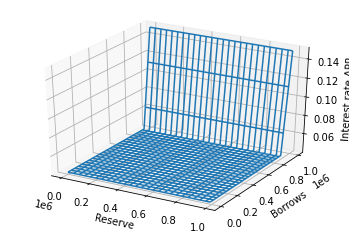

In [2]:
#Plot the borrows function
fig = plt.figure()
ax = fig.gca(projection='3d')

reserves = np.arange(0, 1000000, 10000)
supply = 1000000
borrows = np.arange(0, 1000000, 10000)
R, B = np.meshgrid(reserves, borrows)

br_dict = {}
supply_upscaled = supply * int(1e18)
for b in borrows:
    b_upscaled = int(b) * int(1e18)
    for r in reserves:
        r_upscaled = int(r) * int(1e18)
        cash_upscaled = supply_upscaled - b_upscaled + r_upscaled
        br = dai_rate_model.get_borrow_rate(cash=cash_upscaled, borrows=b_upscaled, reserves=r_upscaled, regime_params=PARAM_REGIMES[PARAM_REGIME_NUMS['1']])
        br_downscaled_APR = (br) / int(1e18)* dai_rate_model.BLOCKS_PER_YEAR
        # util = dai_rate_model.utilization_rate(cash = cash_upscaled, borrows=b_upscaled, reserves=r_upscaled) / int(1e18)
        br_dict[(r_upscaled,b_upscaled)] = br_downscaled_APR

Z_br = np.empty((100,100))
Z_br[:] = np.NaN

for key in br_dict:
    i = int(key[0] / int(1e22))
    j = int(key[1] / int(1e22))
    Z_br[j][i] = br_dict[key]

surf = ax.plot_wireframe(X=R, Y=B, Z=Z_br, rcount = 30, ccount= 30, antialiased=True)

ax.set_xlabel('Reserve')
ax.set_ylabel('Borrows')
ax.set_zlabel('Interest rate APR')
plt.show()

#State the objective function for interest rates. what are we trying to maximize? Thing to include: stability, efficiency, responsiveness, economic security?
#Propose a new interest rate model that would maximize these factors, for each protocol given the supply and demand that was experienced, what would the interest rates look like? 
 # - Here, probably cannot make the assumption that supply and demand would remain the same, since these are endogenous to the original system parameters. However, could simulate the behaviour for random supply and demand, or normally distributed supply and demand?

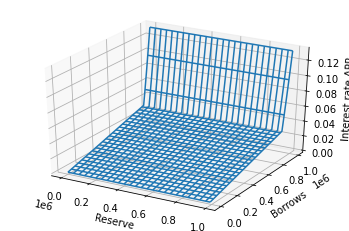

In [3]:
#Plot the supply function - amount saver makes as borrow changes
fig = plt.figure()
ax = fig.gca(projection='3d')

sr_dict = {}
supply_upscaled = supply * int(1e18)
for b in borrows:
    b_upscaled = int(b) * int(1e18)
    for r in reserves:
        r_upscaled = int(r) * int(1e18)
        cash_upscaled = supply_upscaled - b_upscaled + r_upscaled
        br = dai_rate_model.get_supply_rate(cash=cash_upscaled, borrows=b_upscaled, reserves=r_upscaled, regime_params=PARAM_REGIMES[PARAM_REGIME_NUMS['1']])
        sr_downscaled_APY = (br) / int(1e18)* dai_rate_model.BLOCKS_PER_YEAR
        sr_dict[(r_upscaled,b_upscaled)] = sr_downscaled_APY

Z_sr = np.empty((100,100))
Z_sr[:] = np.NaN

for key in sr_dict:
    i = int(key[0] / int(1e22))
    j = int(key[1] / int(1e22))
    Z_sr[j][i] = sr_dict[key]

surf = ax.plot_wireframe(R, B, Z_sr, rcount = 30, ccount= 30, antialiased=True)

ax.set_xlabel('Reserve')
ax.set_ylabel('Borrows')
ax.set_zlabel('Interest rate APR')
plt.show()

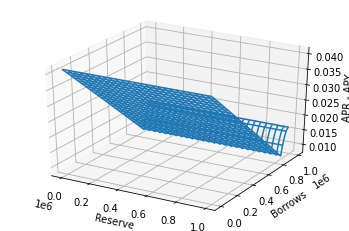

In [4]:
#Plot the delta between APY and APR
#Plot the supply function - amount saver makes as borrow changes
fig = plt.figure()
ax = fig.gca(projection='3d')

Z_delta = Z_br - Z_sr

surf = ax.plot_wireframe(R, B, Z_delta, rcount = 30, ccount= 30, antialiased=True)

ax.set_xlabel('Reserve')
ax.set_ylabel('Borrows')
ax.set_zlabel('APR - APY')
plt.show()

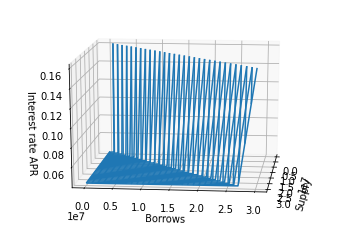

In [5]:
#Interesting, but the above could probably have been plotted in 2D. How about varying supply and borrow?

#Borrow rate
fig = plt.figure()
ax = fig.gca(projection='3d')

reserves = 0 # Arbitrary
supply = np.arange(0, 30000000, 100000)
borrows = np.arange(0, 30000000, 100000)
S, B = np.meshgrid(supply, borrows)

br_dict = {}
r_upscaled = reserves * int(1e18)
for b in borrows:
    b_upscaled = int(b) * int(1e18)
    for s in supply:
        if s<b:
            continue
        s_upscaled = int(s) * int(1e18)
        cash_upscaled = s_upscaled - b_upscaled + r_upscaled
        br = dai_rate_model.get_borrow_rate(cash=cash_upscaled, borrows=b_upscaled, reserves=r_upscaled, regime_params=PARAM_REGIMES[PARAM_REGIME_NUMS['1']])
        br_downscaled_APR = (br) / int(1e18)* dai_rate_model.BLOCKS_PER_YEAR
        # util = dai_rate_model.utilization_rate(cash = cash_upscaled, borrows=b_upscaled, reserves=r_upscaled) / int(1e18)
        br_dict[(s_upscaled,b_upscaled)] = br_downscaled_APR
        
Z_br = np.empty((300,300))
Z_br[:] = np.NaN

for key in br_dict:
    i = int(key[0] / int(1e23))
    j = int(key[1] / int(1e23))
    Z_br[j][i] = br_dict[key]

surf = ax.plot_wireframe(X=S, Y=B, Z=Z_br, rcount = 30, ccount= 30, antialiased=True)

ax.set_xlabel('Supply')
ax.set_ylabel('Borrows')
ax.set_zlabel('Interest rate APR')
ax.view_init(elev=15, azim=6)
fig.savefig('../overleaf/5e6bad2e6490390001d3c466/images/compound-apr.pdf', bbox_inches='tight', dpi = 300)
plt.show()

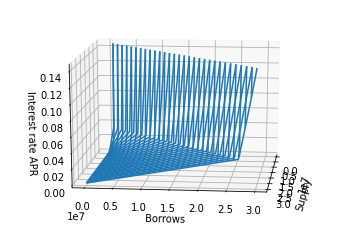

In [6]:
#Supply rate
fig = plt.figure()
ax = fig.gca(projection='3d')

sr_dict = {}
r_upscaled = reserves * int(1e18)
for b in borrows:
    b_upscaled = int(b) * int(1e18)
    for s in supply:
        if s<b:
            continue
        s_upscaled = int(s) * int(1e18)
        cash_upscaled = s_upscaled - b_upscaled + r_upscaled
        sr = dai_rate_model.get_supply_rate(cash=cash_upscaled, borrows=b_upscaled, reserves=r_upscaled, regime_params=PARAM_REGIMES[PARAM_REGIME_NUMS['1']])
        sr_downscaled_APR = (sr) / int(1e18)* dai_rate_model.BLOCKS_PER_YEAR
        # util = dai_rate_model.utilization_rate(cash = cash_upscaled, borrows=b_upscaled, reserves=r_upscaled) / int(1e18)
        sr_dict[(s_upscaled,b_upscaled)] = sr_downscaled_APR

Z_sr = np.empty((300,300))
Z_sr[:] = np.NaN

for key in sr_dict:
    i = int(key[0] / int(1e23))
    j = int(key[1] / int(1e23))
    Z_sr[j][i] = sr_dict[key]
    
surf = ax.plot_wireframe(X=S, Y=B, Z=Z_sr, rcount = 30, ccount= 30, antialiased=True)

ax.set_xlabel('Supply')
ax.set_ylabel('Borrows')
ax.set_zlabel('Interest rate APR')
ax.view_init(elev=15, azim=6)
fig.savefig('../overleaf/5e6bad2e6490390001d3c466/images/compound-apy.pdf', bbox_inches='tight', dpi = 300)
plt.show()

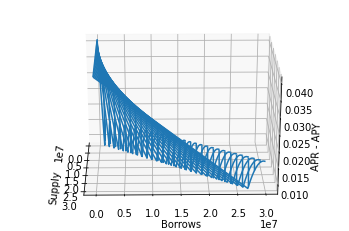

In [7]:
#Delta
fig = plt.figure()
ax = fig.gca(projection='3d')

Z_delta = Z_br - Z_sr

surf = ax.plot_wireframe(S, B, Z_delta, rcount = 30, ccount= 30, antialiased=True)

ax.set_xlabel('Supply')
ax.set_ylabel('Borrows')
ax.set_zlabel('APR - APY')
ax.view_init(elev=23, azim=-1)
fig.savefig('../overleaf/5e6bad2e6490390001d3c466/images/compound-apr-apy-delta.pdf', bbox_inches='tight', dpi = 300)
plt.show()

In [8]:
#Where to go next? --> Risk adjustment; once adjusted for a risk premium, what are you really getting here?
#Incentives for agents at the kinkds. What are they? Ideally an agent should be able to borrow funds at their MWP
#By the time in the steep section and the rates are increasing, relying on others to step in to offer liquidity to avoid a default.
#But the window is quite compressed
#How to quantify the default risk?
#Given that the borrow rate can become very high, could you end up in a situation where sellers coordinate to restrict supply, getting the highest interest rate?
#--> market manipulation
###--> Introduce term structure. What if funds, once supplied, could not be withdrawn for a certain period? 
###-> Given these functions, what interest rates do we actually observe? What would optimal behaviour suggest, and how does this compare to what is observed?